## Import data & libraries

In [4]:
import quandl
import investpy

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import missingno as msno
#from google.colab import data_table
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from google.colab import data_table
import xgboost as xgb
from tqdm import tqdm
from sklearn.linear_model import SGDRegressor,PassiveAggressiveRegressor
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Activation,Embedding,LSTM,Concatenate,Flatten,Dropout,Bidirectional
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam 
from tensorflow.keras import callbacks,Sequential
import tensorflow as tf
from datetime import datetime
import pytz
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import backend as K
import shutil,os
import pickle

In [7]:
final_df = pd.read_csv('final_df_next_day_20210919_10.csv').reset_index(drop=True)
final_df.tail()

,Date,sma90 avg_transaction_value,wma30 avg_transaction_value,closing_price,dema7 opening_price,ema90 avg_transaction_value,tema30 highest_price,opening_price,tema7 closing_price,ema30 avg_transaction_value,dema90 avg_transaction_value,next_day_closing_price
3088,2021-09-14,0.962009,1.000000,0.740622,0.713871,0.987119,0.777173,0.707069,0.719939,1.000000,0.996045,48130.6
3089,2021-09-15,0.971827,0.992880,0.757213,0.724588,0.991312,0.776191,0.740477,0.740076,0.987087,0.996319,47748.0
3090,2021-09-16,0.982980,0.989533,0.751185,0.739332,0.997794,0.775406,0.757200,0.748003,0.979753,1.000000,47282.8
3091,2021-09-17,0.991883,0.974805,0.743856,0.746433,0.998428,0.773731,0.751149,0.747889,0.961515,0.995155,48306.7
3092,2021-09-18,1.000000,0.961588,0.759987,0.747853,1.000000,0.773977,0.743835,0.756739,0.946353,0.991800,47238.7


In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    return MAE,RMSE

def plot_results(y,ypred,title=None):
    plt.figure(figsize=(25,5))
    plt.plot(y,label='actual')
    plt.plot(ypred,label='predicted')
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.show()

## Train Test Split

In [9]:
train_window = 500
test_window = 100
train_splits = []
test_splits = []
for i in tqdm(range(train_window, len(final_df),test_window)):
    train_split = final_df[i-train_window:i]
    test_split = final_df[i:i+test_window]
    train_splits.append(train_split)
    test_splits.append(test_split)

100%|██████████| 26/26 [00:00<00:00, 3638.10it/s]


In [10]:
len(train_splits)

26

In [11]:
def visualize_split(batch_no,show_plot=True):
    final_df.plot(x='Date',y='next_day_closing_price',figsize=(25,5))
    for i in range(train_splits[batch_no].index[0],train_splits[batch_no].index[-1]):
        plt.axvline(x=i,color='r',alpha=0.1)
    for i in range(test_splits[batch_no].index[0],test_splits[batch_no].index[-1]):
        plt.axvline(x=i,color='b',alpha=0.1)
    plt.grid()
    plt.legend('')
    plt.title(f'Temporal Window Split-{batch_no+1}')
    if not os.path.exists('/content/plot'):
        os.makedirs('/content/plot')
        
    plt.savefig(f'/content/plot/Temporal Window Split-{batch_no+1}.png')
    plt.show()

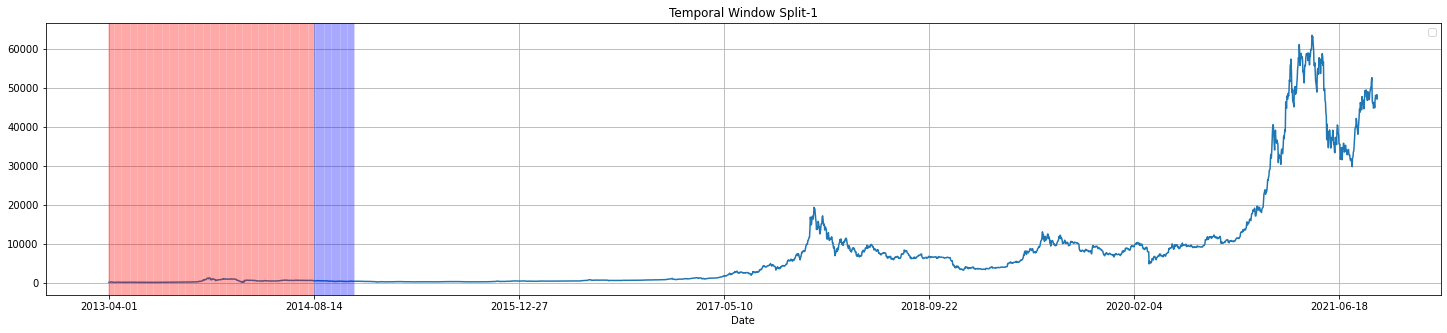

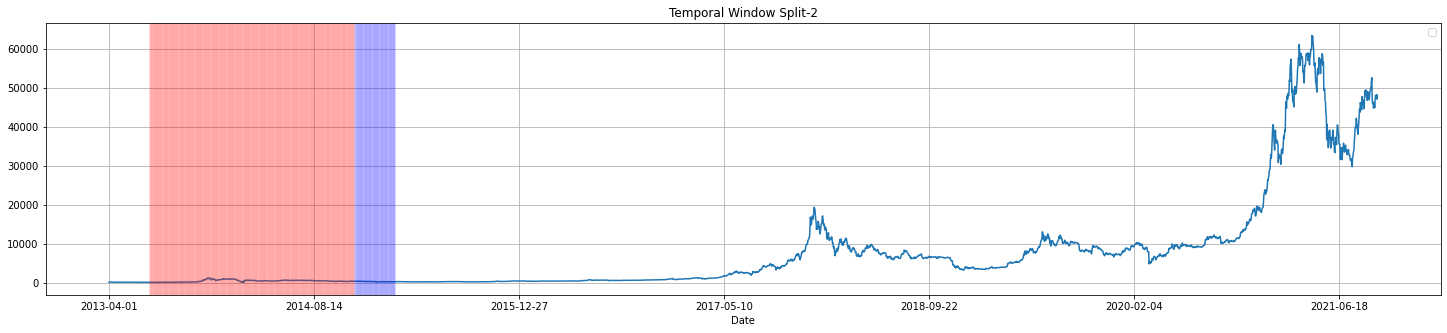

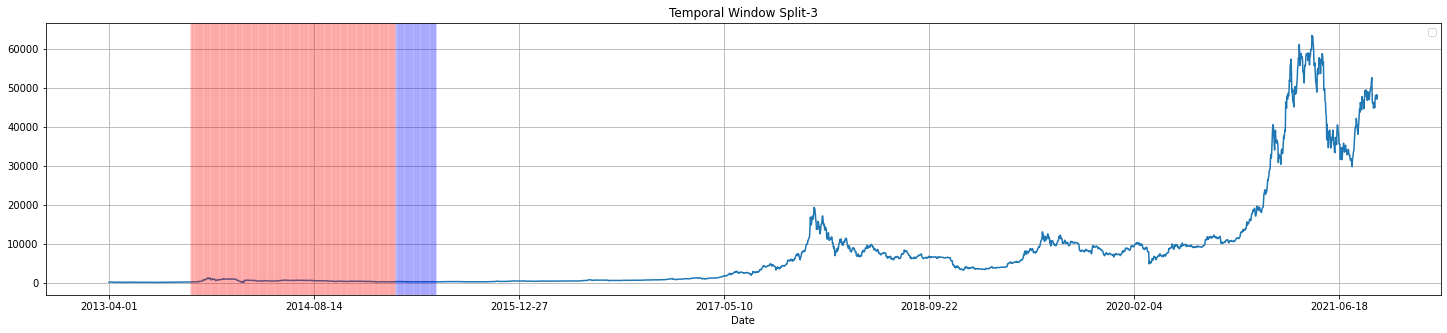

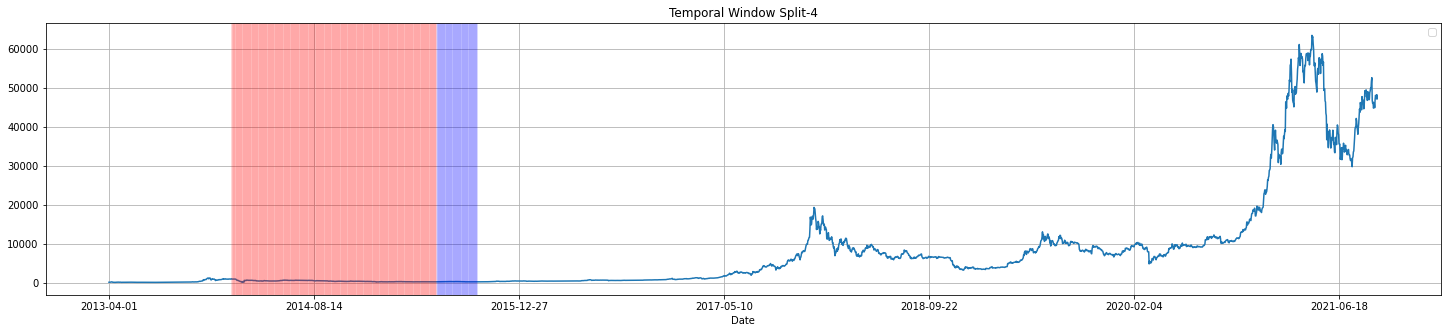

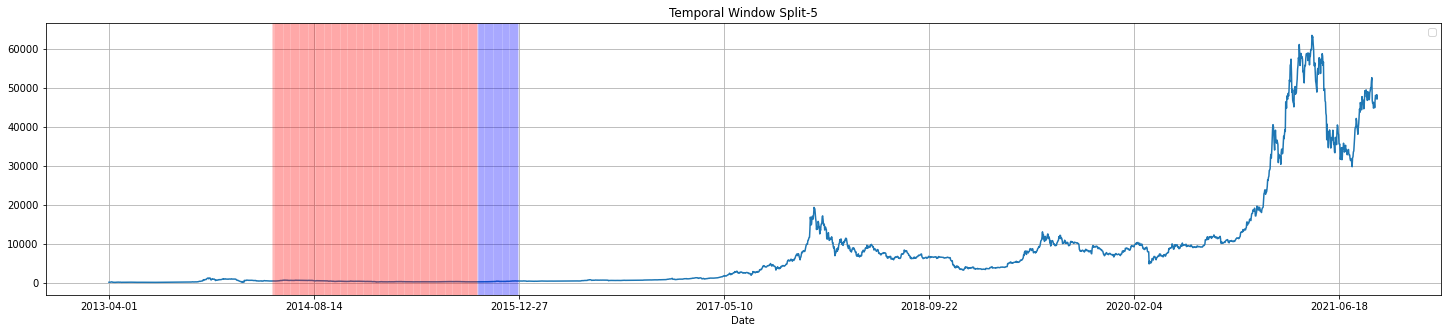

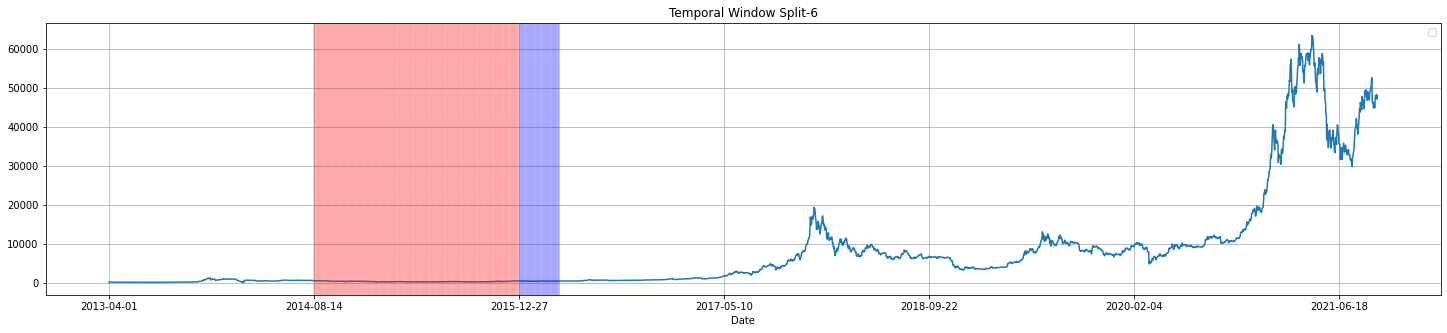

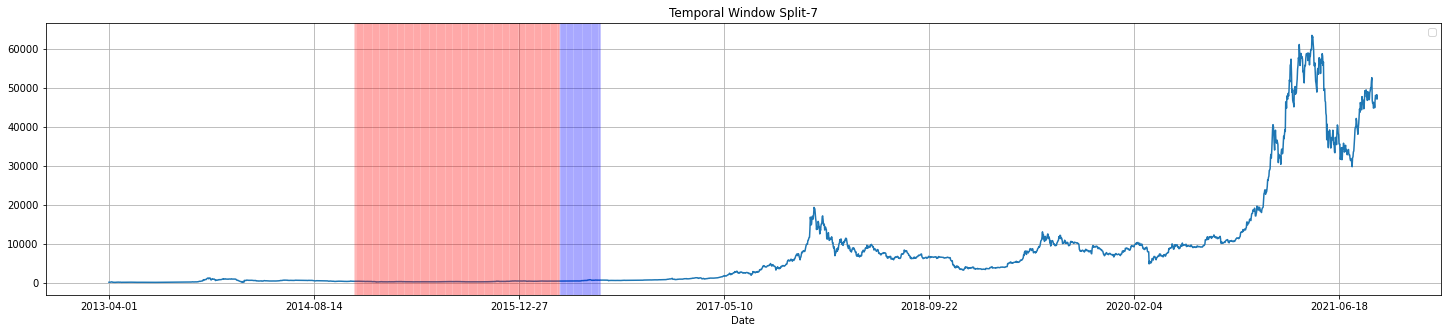

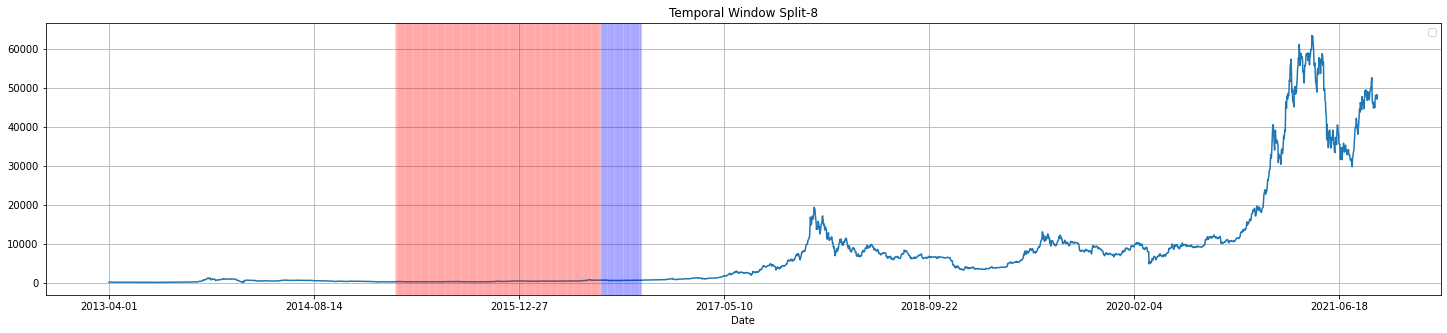

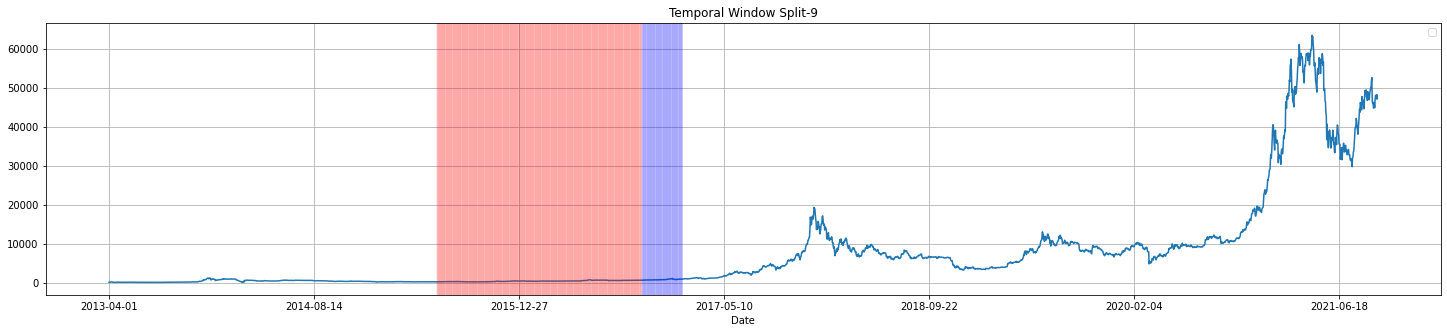

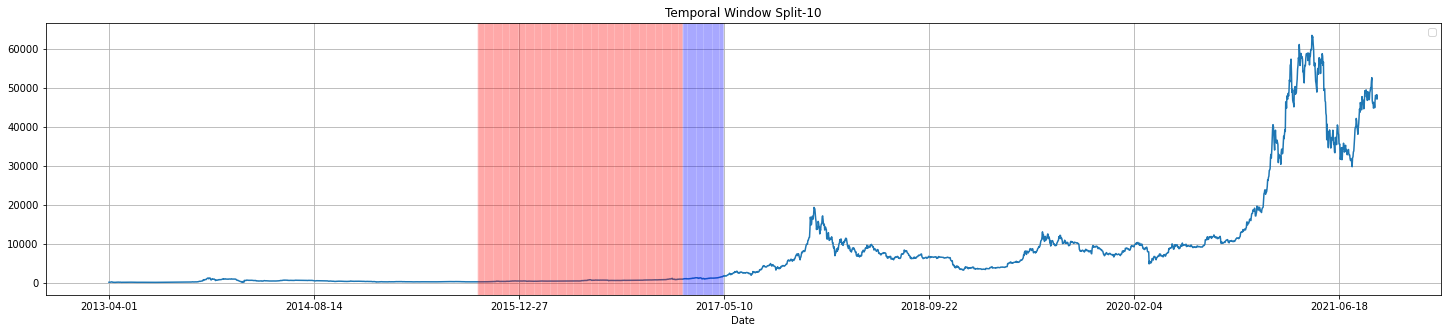

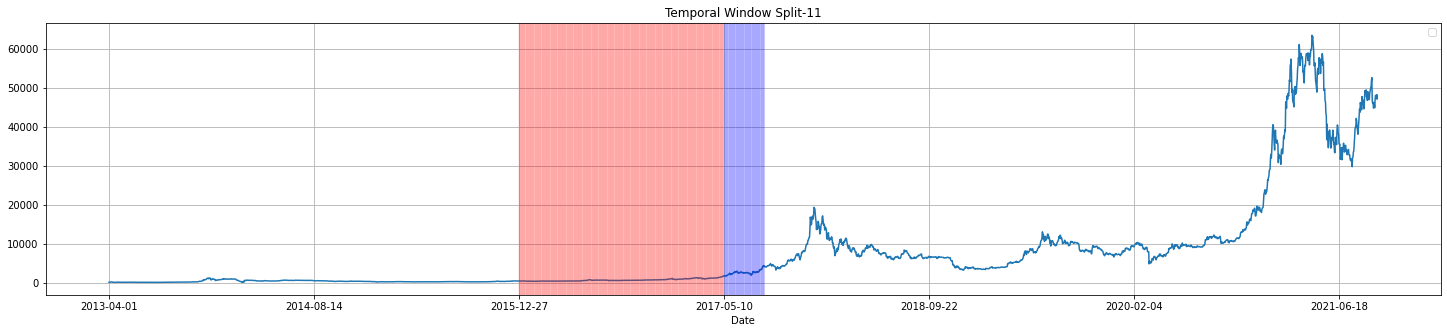

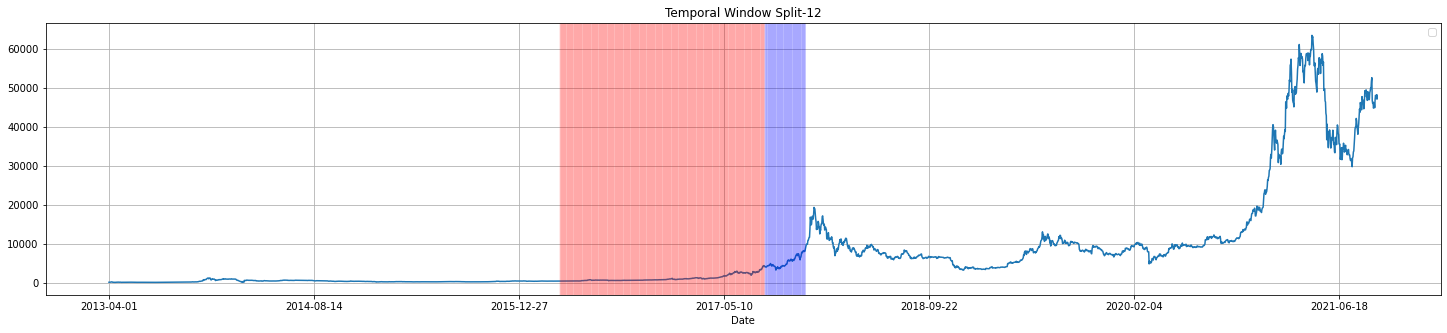

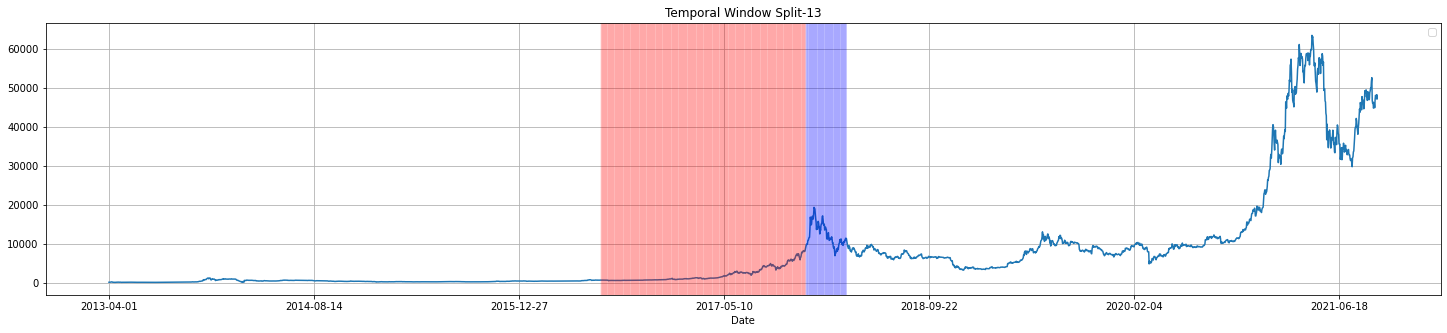

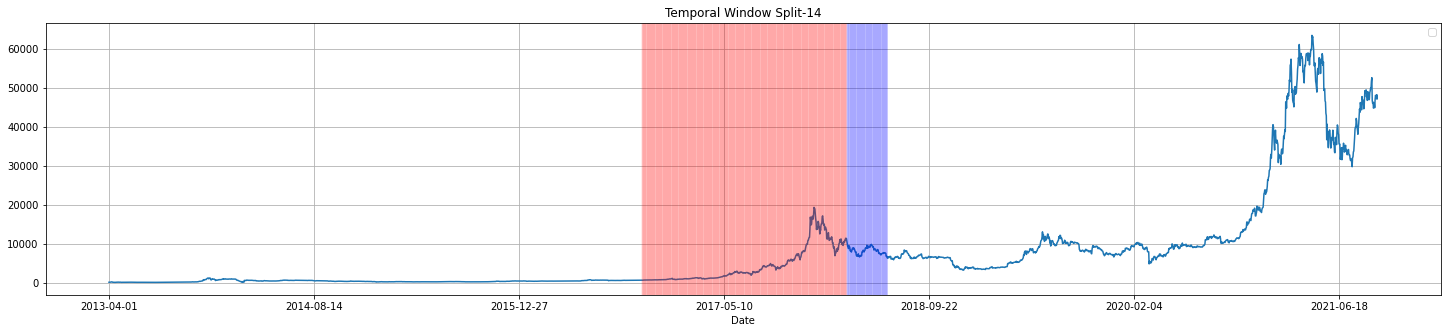

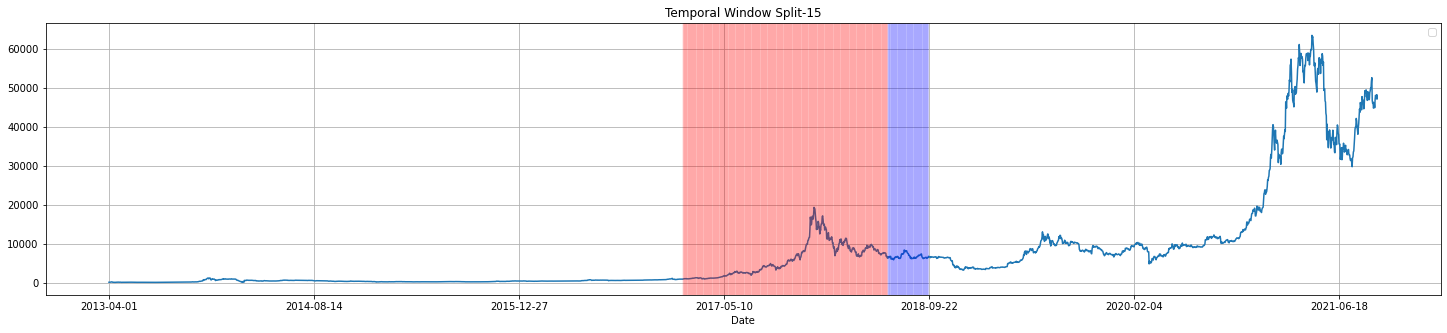

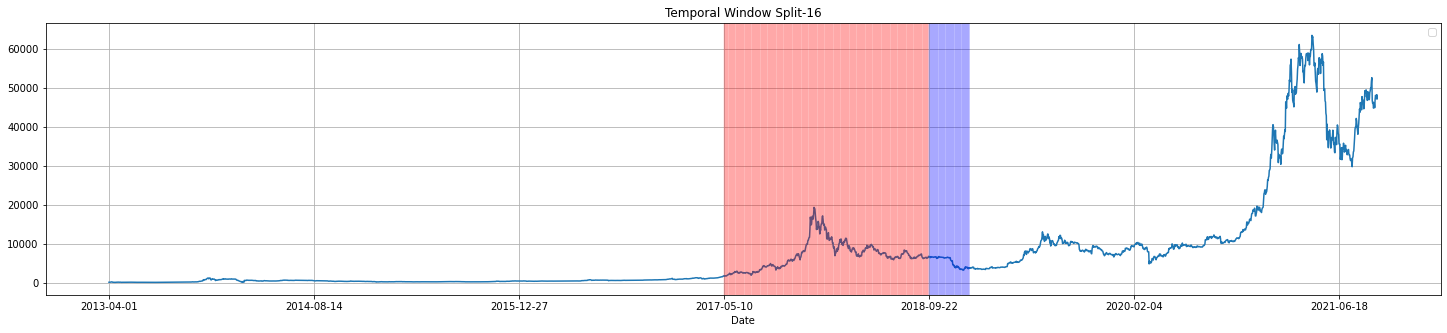

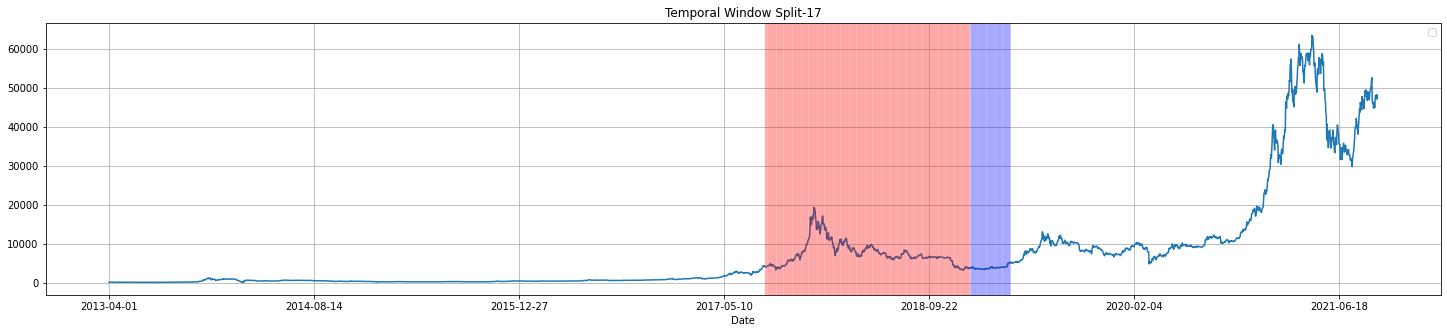

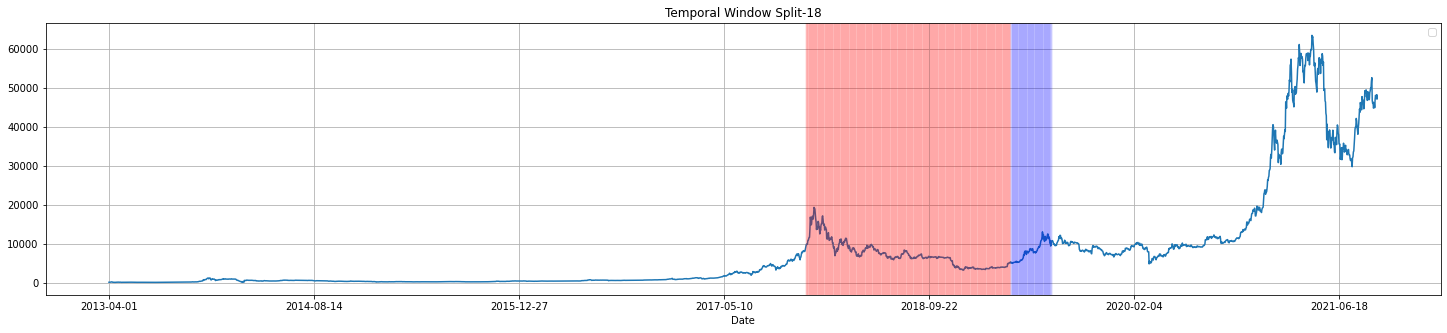

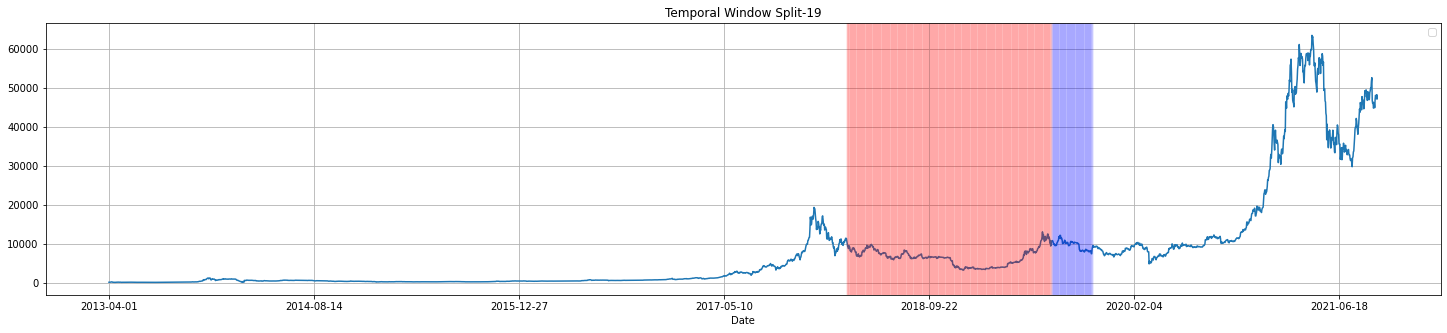

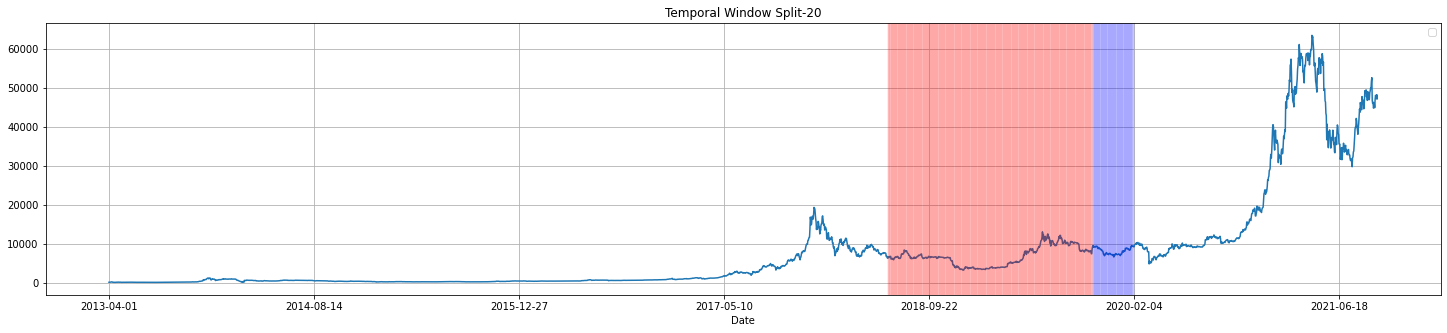

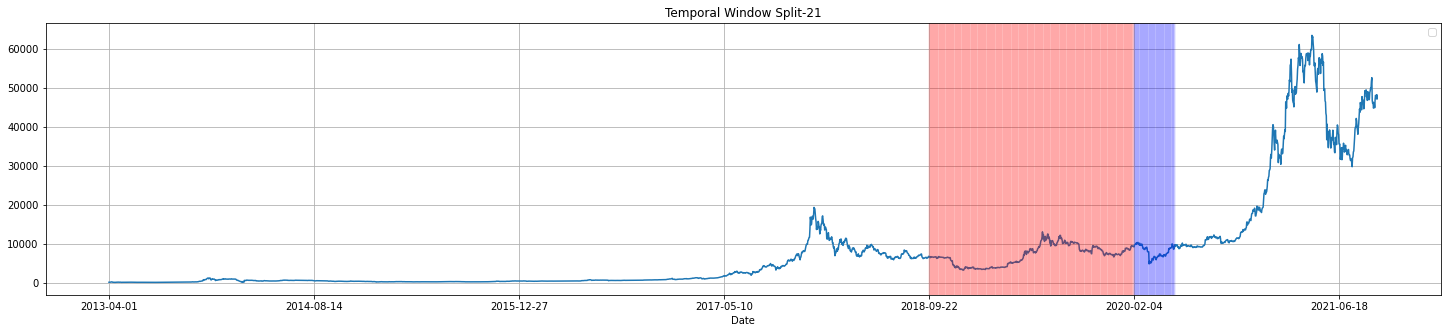

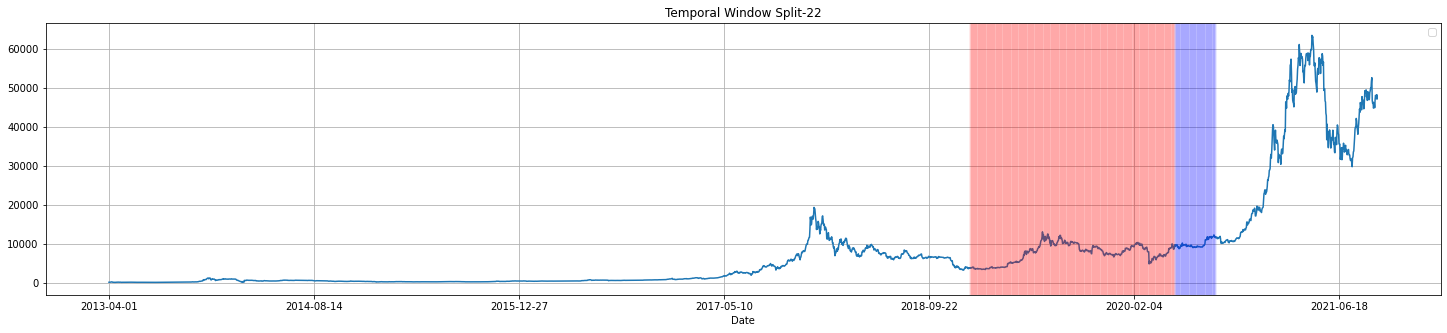

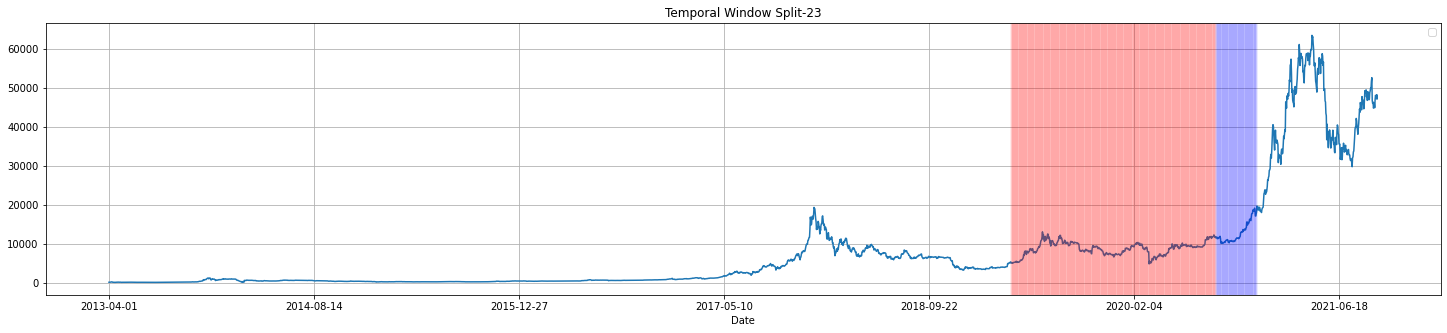

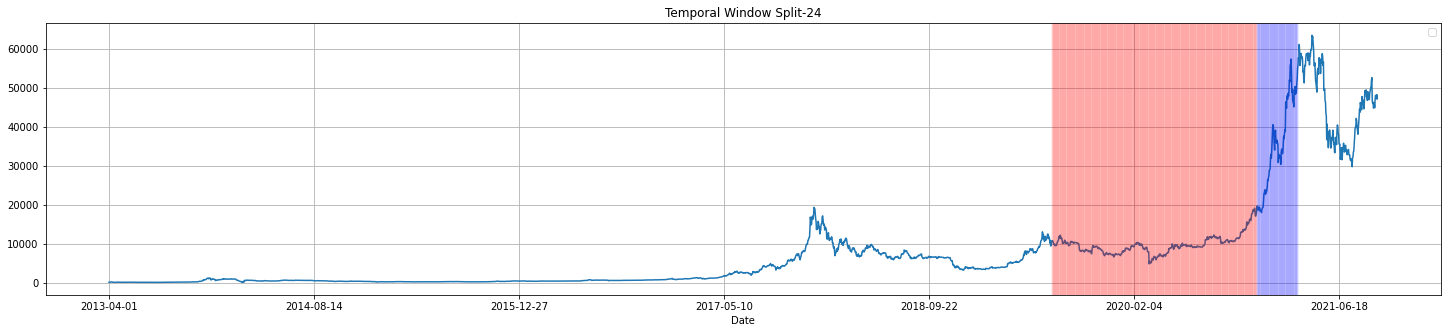

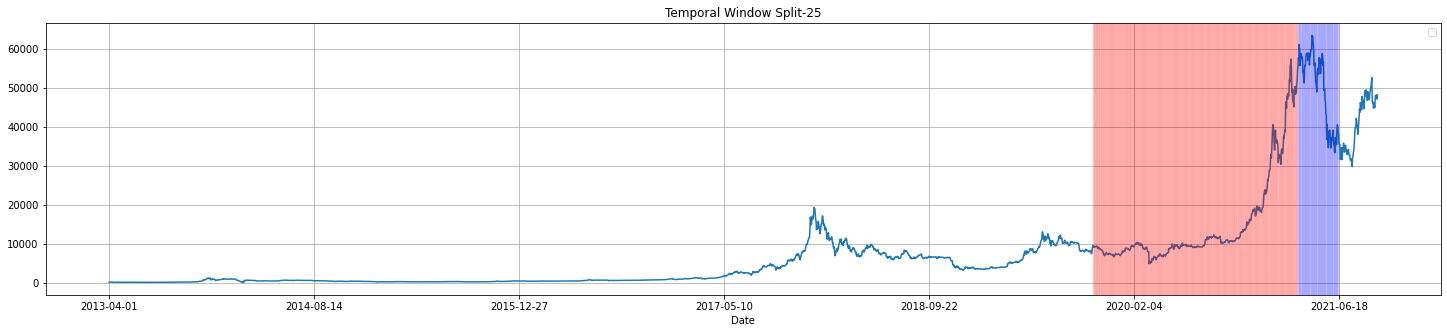

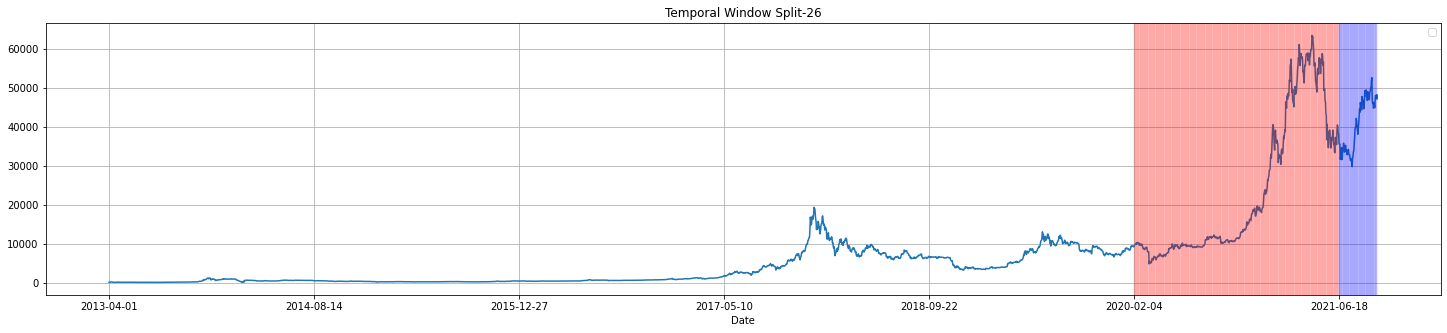

In [ ]:
for i in range(len(train_splits)):
    visualize_split(i)

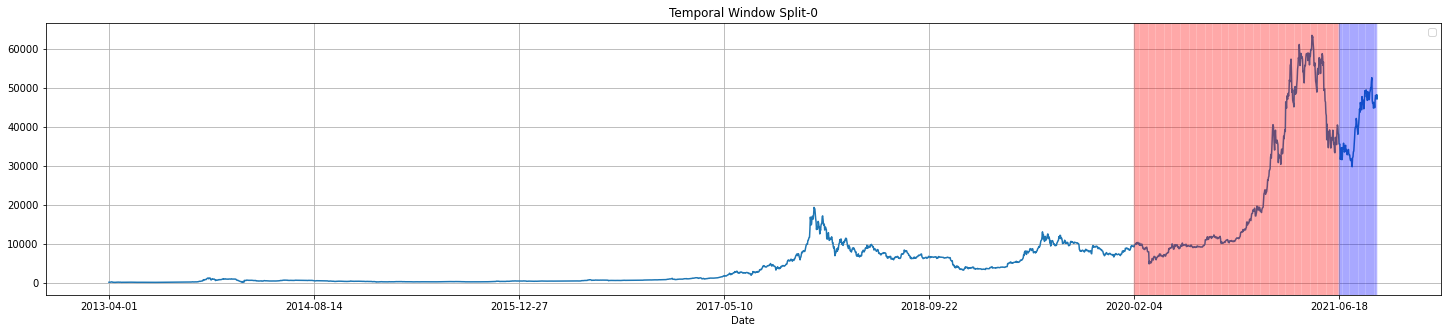

In [ ]:
visualize_split(-1)

## SVR

In [ ]:
svr_date_array = []
svr_y_test_array = []
svr_y_test_pred_array = []
svr_batch_id_array = []
svr_batch_id_array_result = []
svr_batch_mae_train_array = []
svr_batch_rmse_train_array = []
svr_batch_mae_test_array = []
svr_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    svr = SVR(C=10000,gamma='auto',kernel='rbf')
    svr.fit(Xtrain_split, ytrain_split)

    ytrain_pred = svr.predict(Xtrain_split)
    ytest_pred = svr.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    svr_date_array.extend(test_splits[i]['Date'])
    svr_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    svr_y_test_pred_array.extend((ytest_pred.flatten()))
    svr_batch_id_array.extend([i]*len(test_splits[i]))

    svr_batch_id_array_result.append(i)
    svr_batch_mae_train_array.append(MAE_train)
    svr_batch_rmse_train_array.append(RMSE_train)
    svr_batch_mae_test_array.append(MAE_test)
    svr_batch_rmse_test_array.append(RMSE_test)

svr_result_test_df = pd.DataFrame()
svr_result_test_df['batch_id'] = svr_batch_id_array
svr_result_test_df['Date'] = svr_date_array
svr_result_test_df['y_test'] = svr_y_test_array
svr_result_test_df['y_test_pred'] = svr_y_test_pred_array
svr_y_test_array = svr_result_test_df['y_test']
svr_y_test_pred_array = svr_result_test_df['y_test_pred']
svr_result_metrics_df = pd.DataFrame()
svr_result_metrics_df['batch_id'] = svr_batch_id_array_result
svr_result_metrics_df['mae_train'] = svr_batch_mae_train_array
svr_result_metrics_df['rmse_train'] = svr_batch_rmse_train_array
svr_result_metrics_df['mae_test'] = svr_batch_mae_test_array
svr_result_metrics_df['rmse_test'] = svr_batch_rmse_test_array

100%|██████████| 26/26 [00:02<00:00,  9.99it/s]


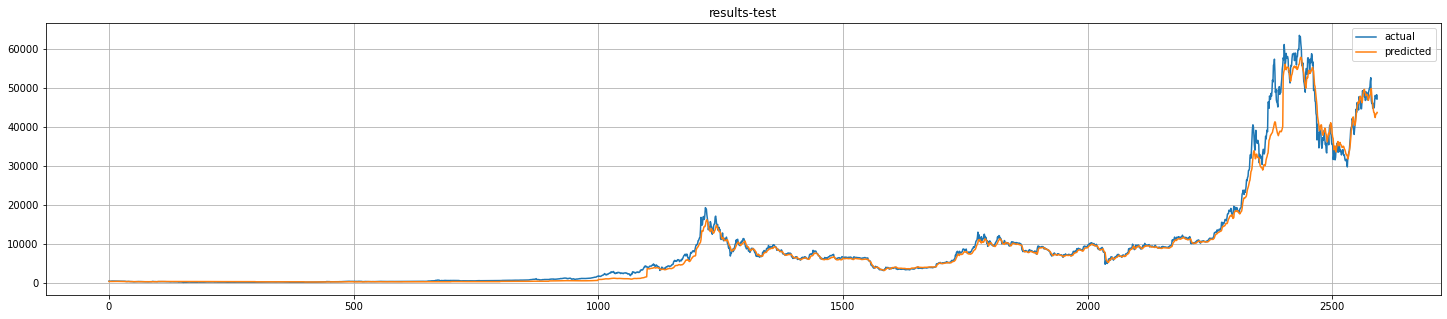

In [ ]:
plot_results(svr_y_test_array,svr_y_test_pred_array,'results-test')

In [ ]:
svr_result_metrics_df

,batch_id,mae_train,rmse_train,mae_test,rmse_test
0,0,120.367930,143.137339,37.557171,47.589100
1,1,119.315354,151.550344,100.107735,107.562541
2,2,111.801893,146.425888,130.120946,130.778461
3,3,94.885977,118.019405,81.225696,83.626687
4,4,82.535137,113.764954,46.950195,56.673283
5,5,53.435309,70.804247,78.105413,84.732816
6,6,41.612811,52.430544,203.685458,228.408946
7,7,62.762662,95.314978,238.163164,239.792159
8,8,95.733579,119.221376,344.970803,355.841261
9,9,123.549507,157.757281,581.301647,598.117689


In [ ]:
pd.DataFrame(svr_result_metrics_df.mean()).drop(['batch_id'])

,0
mae_train,239.838546
rmse_train,380.781326
mae_test,738.697268
rmse_test,898.226368


In [ ]:
metrics.mean_absolute_percentage_error(ytest_split,ytest_pred)

0.04212858384421766

In [ ]:
svr_result_test_df.to_csv(r'C:\Users\Parth Modi\Desktop\Data Science 1\bitcoin-price-forecasting-main\Result\svr_result_test_20210922.csv')
svr_result_metrics_df.to_csv(r'C:\Users\Parth Modi\Desktop\Data Science 1\bitcoin-price-forecasting-main\Result\svr_result_metrics_20210922.csv')

## XGBoost

In [26]:
xgb_date_array = []
xgb_y_test_array = []
xgb_y_test_pred_array = []
xgb_batch_id_array = []
xgb_batch_id_array_result = []
xgb_batch_mae_train_array = []
xgb_batch_rmse_train_array = []
xgb_batch_mape_train_array = []
xgb_batch_mae_test_array = []
xgb_batch_rmse_test_array = []
xgb_batch_mape_test_array = []
for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    xgbm_reg = xgb.XGBRegressor(n_estimators=500,max_depth=3,objective='reg:squarederror',
                                learning_rate =0.01,n_jobs=-1)
    xgbm_reg.fit(Xtrain_split, ytrain_split)

    ytrain_pred = xgbm_reg.predict(Xtrain_split)
    ytest_pred = xgbm_reg.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    xgb_date_array.extend(test_splits[i]['Date'])
    xgb_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    xgb_y_test_pred_array.extend((ytest_pred.flatten()))
    xgb_batch_id_array.extend([i]*len(test_splits[i]))

    xgb_batch_id_array_result.append(i)
    xgb_batch_mae_train_array.append(MAE_train)
    xgb_batch_rmse_train_array.append(RMSE_train)
    xgb_batch_mae_test_array.append(MAE_test)
    xgb_batch_rmse_test_array.append(RMSE_test)

xgb_result_test_df = pd.DataFrame()
xgb_result_test_df['batch_id'] = xgb_batch_id_array
xgb_result_test_df['Date'] = xgb_date_array
xgb_result_test_df['y_test'] = xgb_y_test_array
xgb_result_test_df['y_test_pred'] = xgb_y_test_pred_array
xgb_y_test_array = xgb_result_test_df['y_test']
xgb_y_test_pred_array = xgb_result_test_df['y_test_pred']
xgb_result_metrics_df = pd.DataFrame()
xgb_result_metrics_df['batch_id'] = xgb_batch_id_array_result
xgb_result_metrics_df['mae_train'] = xgb_batch_mae_train_array
xgb_result_metrics_df['rmse_train'] = xgb_batch_rmse_train_array
xgb_result_metrics_df['mae_test'] = xgb_batch_mae_test_array
xgb_result_metrics_df['rmse_test'] = xgb_batch_rmse_test_array

100%|██████████| 26/26 [00:08<00:00,  2.98it/s]


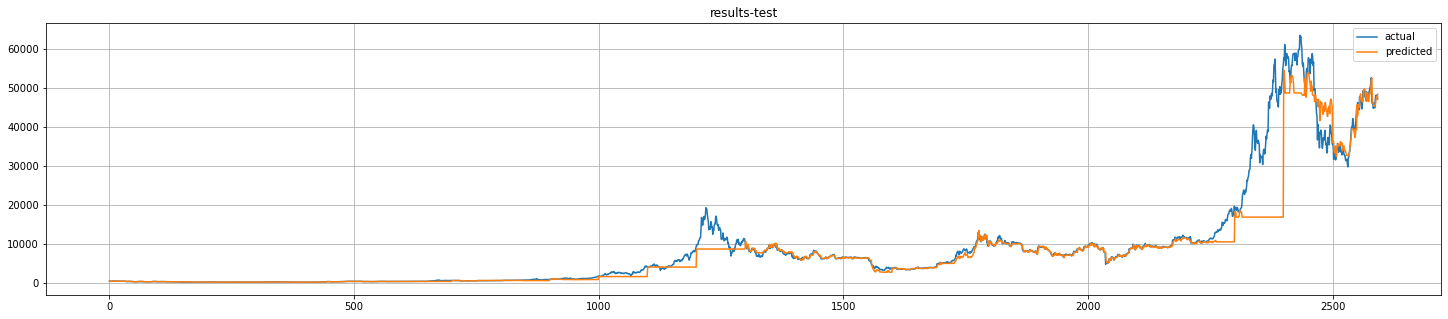

In [ ]:
plot_results(xgb_y_test_array,xgb_y_test_pred_array,'results-test')

In [ ]:
xgb_result_metrics_df

,batch_id,mae_train,rmse_train,mae_test,rmse_test
0,0,13.392677,24.238510,22.652253,29.717459
1,1,14.050814,24.609200,31.780496,38.649169
2,2,15.137164,24.640822,6.492042,8.373212
3,3,9.349542,13.997975,6.237693,8.924927
4,4,5.890234,8.190572,13.213529,19.392910
5,5,5.346288,7.505422,8.347208,11.269503
6,6,4.836913,6.761919,109.669418,150.727908
7,7,4.913235,7.164984,29.906651,37.996283
8,8,5.723564,8.761568,152.956473,193.017042
9,9,7.665748,12.299380,245.451834,307.717349


In [ ]:
pd.DataFrame(xgb_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
mae_train,106.392391
rmse_train,170.269359
mae_test,1502.742504
rmse_test,1829.442619


In [ ]:
xgb_result_test_df.to_csv(r'C:\Users\Parth Modi\Desktop\Data Science 1\bitcoin-price-forecasting-main\Result\xgb_result_test_20210922.csv')
xgb_result_metrics_df.to_csv(r'C:\Users\Parth Modi\Desktop\Data Science 1\bitcoin-price-forecasting-main\Result\xgb_result_metrics_20210922.csv')

## Linear Regression

In [ ]:
lr_date_array = []
lr_y_test_array = []
lr_y_test_pred_array = []
lr_batch_id_array = []
lr_batch_id_array_result = []
lr_batch_mae_train_array = []
lr_batch_rmse_train_array = []
lr_batch_mae_test_array = []
lr_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    sgd_reg = SGDRegressor(loss='squared_epsilon_insensitive',alpha=0.0001,penalty='elasticnet',shuffle=True,
                           tol=0.000001,l1_ratio=0.15,epsilon=0.01,learning_rate='adaptive',max_iter=1000,eta0 =0.01)
    sgd_reg.fit(Xtrain_split, ytrain_split)

    #pickle.dump(sgd_reg, open(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/Linear Regression Model/linear_reg_10_{i}.sav', 'wb'))

    ytrain_pred = sgd_reg.predict(Xtrain_split)
    ytest_pred = sgd_reg.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    lr_date_array.extend(test_splits[i]['Date'])
    lr_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    lr_y_test_pred_array.extend((ytest_pred.flatten()))
    lr_batch_id_array.extend([i]*len(test_splits[i]))

    lr_batch_id_array_result.append(i)
    lr_batch_mae_train_array.append(MAE_train)
    lr_batch_rmse_train_array.append(RMSE_train)
    lr_batch_mae_test_array.append(MAE_test)
    lr_batch_rmse_test_array.append(RMSE_test)

lr_result_test_df = pd.DataFrame()
lr_result_test_df['batch_id'] = lr_batch_id_array
lr_result_test_df['Date'] = lr_date_array
lr_result_test_df['y_test'] = lr_y_test_array
lr_result_test_df['y_test_pred'] = lr_y_test_pred_array
lr_y_test_array = lr_result_test_df['y_test']
lr_y_test_pred_array = lr_result_test_df['y_test_pred']

lr_result_metrics_df = pd.DataFrame()
lr_result_metrics_df['batch_id'] = lr_batch_id_array_result
lr_result_metrics_df['mae_train'] = lr_batch_mae_train_array
lr_result_metrics_df['rmse_train'] = lr_batch_rmse_train_array
lr_result_metrics_df['mae_test'] = lr_batch_mae_test_array
lr_result_metrics_df['rmse_test'] = lr_batch_rmse_test_array

100%|██████████| 26/26 [00:03<00:00,  6.92it/s]


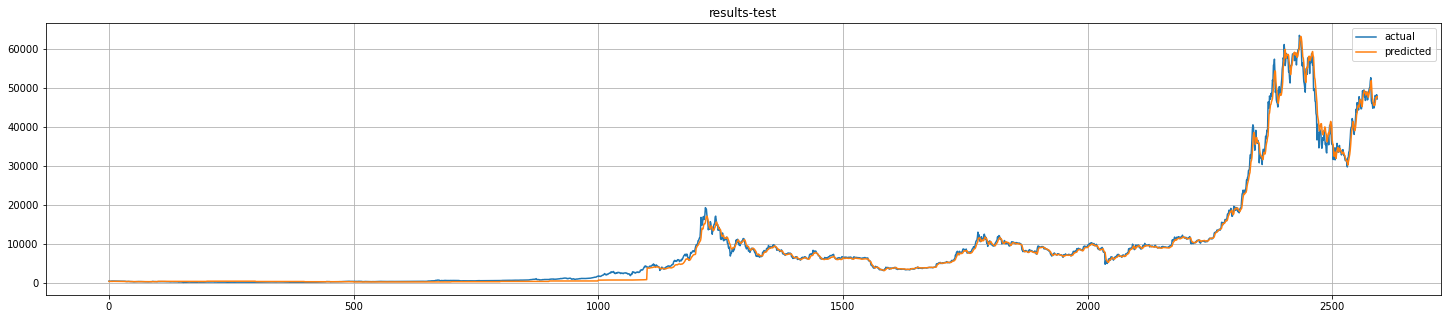

In [ ]:
plot_results(lr_y_test_array,lr_y_test_pred_array,'results-test')

In [ ]:
lr_result_metrics_df

,batch_id,mae_train,rmse_train,mae_test,rmse_test
0,0,132.710950,154.122092,30.330540,37.833143
1,1,166.791308,210.073630,151.874751,159.815089
2,2,163.618167,206.548781,239.861277,240.566932
3,3,134.488871,160.114207,153.089308,154.731613
4,4,114.267743,135.599815,67.417171,78.003252
5,5,67.493775,80.041490,105.791815,107.975575
6,6,66.936273,75.069863,231.336731,254.581835
7,7,101.434105,122.686725,253.228651,255.041961
8,8,117.787038,143.215075,375.829907,388.830370
9,9,153.846662,180.576972,634.138429,654.967060


In [ ]:
pd.DataFrame(lr_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
mae_train,245.425444
rmse_train,378.128307
mae_test,554.610726
rmse_test,681.135007


In [ ]:
lr_result_test_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/lr_result_test_20210922.csv')
lr_result_metrics_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/lr_result_metrics_20210922.csv')

## LSTM

### Callbacks

#### EarlyStopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop=EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=50,verbose=100,mode='min')

####  Learning Rate Scheduler

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
def changeLearningRate(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

lrschedule=LearningRateScheduler(changeLearningRate, verbose=1)

In [ ]:
reduce_lr=ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=3,verbose=1,mode='min')

In [ ]:
callback_list=[reduce_lr,lrschedule,earlystop]

### Build Model

In [ ]:
input_layer = Input(shape=(1, 10),name='input_layer')
lstm_1 = LSTM(400, return_sequences=True,activation='relu',name='lstm_1')(input_layer)
dropout_1 = Dropout(0.25,name='dropout_1')(lstm_1)
lstm_2 = LSTM(500, return_sequences=True,activation='relu',name='lstm_2')(dropout_1)
dropout_2 = Dropout(0.3,name='dropout_2')(lstm_2)
output_layer = Dense(1,name='output_layer')(dropout_2)

model=Model(inputs=input_layer,outputs=output_layer)
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(optimizer=adam, loss='log_cosh',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1, 10)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 400)            657600    
                                                                 
 dropout_1 (Dropout)         (None, 1, 400)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 500)            1802000   
                                                                 
 dropout_2 (Dropout)         (None, 1, 500)            0         
                                                                 
 output_layer (Dense)        (None, 1, 1)              501       
                                                                 
Total params: 2,460,101
Trainable params: 2,460,101
Non-tra

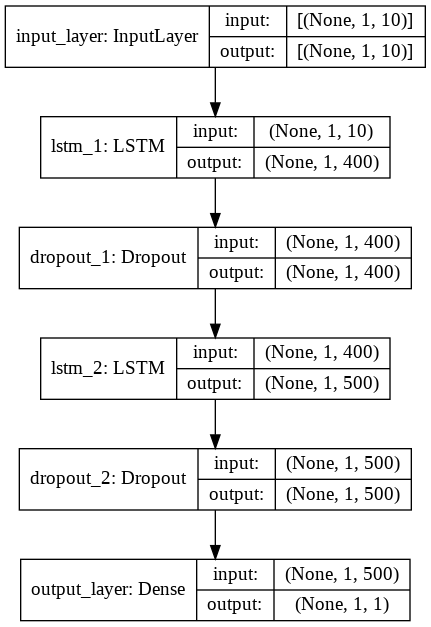

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [ ]:
Xtrain_split.shape

(500, 1, 10)

In [ ]:
lstm_date_array = []
lstm_y_test_array = []
lstm_y_test_pred_array = []
lstm_batch_id_array = []
lstm_batch_id_array_result = []
lstm_batch_mae_train_array = []
lstm_batch_rmse_train_array = []
lstm_batch_mae_test_array = []
lstm_batch_rmse_test_array = []

for i in range(len(train_splits)):
    print(f'Batch No. {i+1} of {len(train_splits)}')
    print('Train Data From',train_splits[i]['Date'].iloc[0],'-',train_splits[i]['next_day_closing_price'].min(),
          'to',train_splits[i]['Date'].iloc[-1],'-',train_splits[i]['next_day_closing_price'].max())
    
    print('Test Data From',test_splits[i]['Date'].iloc[0],'-',test_splits[i]['next_day_closing_price'].min(),
          'to',test_splits[i]['Date'].iloc[-1],'-',test_splits[i]['next_day_closing_price'].max())
    
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(optimizer=adam, loss='Huber',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    Xtrain_split=np.reshape(Xtrain_split,(Xtrain_split.shape[0],1,Xtrain_split.shape[1]))
    Xtest_split=np.reshape(Xtest_split,(Xtest_split.shape[0],1,Xtest_split.shape[1]))

    model.fit(Xtrain_split,ytrain_split,epochs=500,batch_size=32,verbose=2,
              callbacks = [reduce_lr,lrschedule,earlystop])
    
    model.save(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/LSTM/lstm_{i+1}/model.h5')
    ytrain_pred = model.predict(Xtrain_split).reshape(-1,1)
    ytest_pred = model.predict(Xtest_split).reshape(-1,1)
    
    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    lstm_date_array.extend(test_splits[i]['Date'])
    lstm_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    lstm_y_test_pred_array.extend((ytest_pred.flatten()))
    lstm_batch_id_array.extend([i]*len(test_splits[i]))

    lstm_batch_id_array_result.append(i)
    lstm_batch_mae_train_array.append(MAE_train)
    lstm_batch_rmse_train_array.append(RMSE_train)
    lstm_batch_mae_test_array.append(MAE_test)
    lstm_batch_rmse_test_array.append(RMSE_test)
    print('*'*100)

lstm_result_test_df = pd.DataFrame()
lstm_result_test_df['batch_id'] = lstm_batch_id_array
lstm_result_test_df['Date'] = lstm_date_array
lstm_result_test_df['y_test'] = lstm_y_test_array
lstm_result_test_df['y_test_pred'] = lstm_y_test_pred_array
lstm_y_test_array = lstm_result_test_df['y_test']
lstm_y_test_pred_array = lstm_result_test_df['y_test_pred']
lstm_result_metrics_df = pd.DataFrame()
lstm_result_metrics_df['batch_id'] = lstm_batch_id_array_result
lstm_result_metrics_df['mae_train'] = lstm_batch_mae_train_array
lstm_result_metrics_df['rmse_train'] = lstm_batch_rmse_train_array
lstm_result_metrics_df['mae_test'] = lstm_batch_mae_test_array
lstm_result_metrics_df['rmse_test'] = lstm_batch_rmse_test_array

Streaming output truncated to the last 5000 lines.

Epoch 00054: LearningRateScheduler setting learning rate to 0.0005913954228162766.
16/16 - 0s - loss: 480.3744 - root_mean_squared_error: 680.9600 - mae: 480.8744
Epoch 55/500

Epoch 00055: LearningRateScheduler setting learning rate to 0.000579567514359951.
16/16 - 0s - loss: 530.6920 - root_mean_squared_error: 740.8553 - mae: 531.1912

Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.0005679761595092713.
Epoch 56/500

Epoch 00056: LearningRateScheduler setting learning rate to 0.0005679761525243521.
16/16 - 0s - loss: 495.1201 - root_mean_squared_error: 744.3380 - mae: 495.6201
Epoch 57/500

Epoch 00057: LearningRateScheduler setting learning rate to 0.0005679761525243521.
16/16 - 0s - loss: 458.7348 - root_mean_squared_error: 652.8985 - mae: 459.2348
Epoch 58/500

Epoch 00058: LearningRateScheduler setting learning rate to 0.0005679761525243521.
16/16 - 0s - loss: 460.6562 - root_mean_squared_error: 689.6898 - mae: 461.15

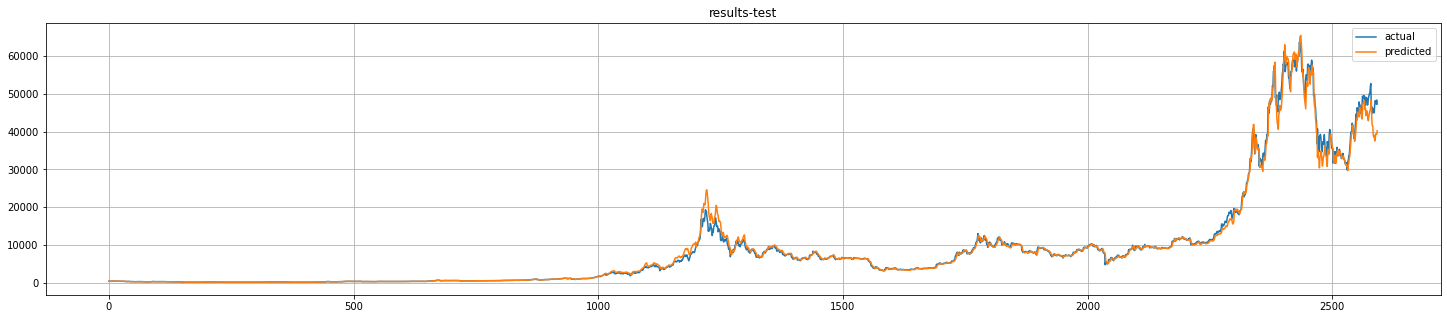

In [ ]:
plot_results(lstm_y_test_array,lstm_y_test_pred_array,'results-test')

In [ ]:
lstm_result_metrics_df

,batch_id,mae_train,rmse_train,mae_test,rmse_test
0,0,41.200406,69.978920,17.772679,23.434166
1,1,30.772172,57.654877,11.381757,16.979772
2,2,28.434527,54.158928,5.667712,7.479782
3,3,16.879980,35.493718,5.572499,7.577191
4,4,9.810473,14.712660,10.760219,16.103701
5,5,8.794498,13.457457,9.259670,12.762473
6,6,7.739354,11.949790,18.421506,28.275985
7,7,8.544108,14.815511,7.480440,14.181857
8,8,9.507583,16.033129,21.448177,35.161301
9,9,11.722373,21.772257,30.662009,44.895739


In [ ]:
pd.DataFrame(lstm_result_metrics_df.mean()).drop(['batch_id'])

,0
mae_train,167.279376
rmse_train,288.141473
mae_test,479.774924
rmse_test,650.818430


In [ ]:
metrics.mean_absolute_percentage_error(ytest_split,ytest_pred)

0.04983572604091162

In [ ]:
lstm_result_metrics_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/lstm_result_metrics_20210922.csv')
lstm_result_test_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/lstm_result_test_20210922.csv')

## BI-LSTM

### Callbacks

#### EarlyStopping

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop=EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=50,verbose=100,mode='min')

####  Learning Rate Scheduler

In [13]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
def changeLearningRate(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

lrschedule=LearningRateScheduler(changeLearningRate, verbose=1)

In [14]:
reduce_lr=ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=3,verbose=1,mode='min')

In [15]:
callback_list=[reduce_lr,lrschedule,earlystop]

### Build Model

In [16]:
input_layer = Input(shape=(1, 10),name='input_layer')
lstm_1 = Bidirectional(LSTM(400, return_sequences=True, activation='relu'),name='lstm_1')(input_layer)
dropout_1 = Dropout(0.25,name='dropout_1')(lstm_1)
lstm_2 = Bidirectional(LSTM(500, return_sequences=True, activation='relu'),name='lstm_2')(dropout_1)
dropout_2 = Dropout(0.3,name='dropout_2')(lstm_2)

output_layer = Dense(1,name='output_layer')(dropout_2)

model=Model(inputs=input_layer,outputs=output_layer)
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(optimizer=adam, loss='log_cosh',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 10)]           0         
_________________________________________________________________
lstm_1 (Bidirectional)       (None, 1, 800)            1315200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 800)            0         
_________________________________________________________________
lstm_2 (Bidirectional)       (None, 1, 1000)           5204000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1000)           0         
_________________________________________________________________
output_layer (Dense)         (None, 1, 1)              1001      
Total params: 6,520,201
Trainable params: 6,520,201
Non-trainable params: 0
___________________________________________________

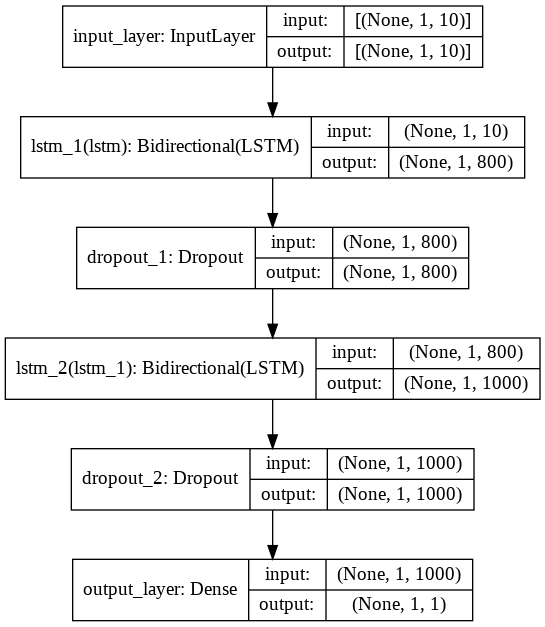

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [20]:
bilstm_date_array = []
bilstm_y_test_array = []
bilstm_y_test_pred_array = []
bilstm_batch_id_array = []
bilstm_batch_id_array_result = []
bilstm_batch_mae_train_array = []
bilstm_batch_rmse_train_array = []
bilstm_batch_mae_test_array = []
bilstm_batch_rmse_test_array = []

for i in range(len(train_splits)):
    print(f'Batch No. {i+1} of {len(train_splits)}')
    print('Train Data From',train_splits[i]['Date'].iloc[0],'-',train_splits[i]['next_day_closing_price'].min(),
          'to',train_splits[i]['Date'].iloc[-1],'-',train_splits[i]['next_day_closing_price'].max())
    
    print('Test Data From',test_splits[i]['Date'].iloc[0],'-',test_splits[i]['next_day_closing_price'].min(),
          'to',test_splits[i]['Date'].iloc[-1],'-',test_splits[i]['next_day_closing_price'].max())
    
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(optimizer=adam, loss='Huber',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    Xtrain_split=np.reshape(Xtrain_split,(Xtrain_split.shape[0],1,Xtrain_split.shape[1]))
    Xtest_split=np.reshape(Xtest_split,(Xtest_split.shape[0],1,Xtest_split.shape[1]))

    model.fit(Xtrain_split,ytrain_split,epochs=500,batch_size=32,verbose=2,
              callbacks = [reduce_lr,lrschedule,earlystop])
    model.save(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/BI-LSTM/bilstm_{i+1}/model.h5')
    ytrain_pred = model.predict(Xtrain_split).reshape(-1,1)
    ytest_pred = model.predict(Xtest_split).reshape(-1,1)
    
    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    bilstm_date_array.extend(test_splits[i]['Date'])
    bilstm_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    bilstm_y_test_pred_array.extend((ytest_pred.flatten()))
    bilstm_batch_id_array.extend([i]*len(test_splits[i]))

    bilstm_batch_id_array_result.append(i)
    bilstm_batch_mae_train_array.append(MAE_train)
    bilstm_batch_rmse_train_array.append(RMSE_train)
    bilstm_batch_mae_test_array.append(MAE_test)
    bilstm_batch_rmse_test_array.append(RMSE_test)
    print('*'*100)

bilstm_result_test_df = pd.DataFrame()
bilstm_result_test_df['batch_id'] = bilstm_batch_id_array
bilstm_result_test_df['Date'] = bilstm_date_array
bilstm_result_test_df['y_test'] = bilstm_y_test_array
bilstm_result_test_df['y_test_pred'] = bilstm_y_test_pred_array
bilstm_y_test_array = bilstm_result_test_df['y_test']
bilstm_y_test_pred_array = bilstm_result_test_df['y_test_pred']
bilstm_result_metrics_df = pd.DataFrame()
bilstm_result_metrics_df['batch_id'] = bilstm_batch_id_array_result
bilstm_result_metrics_df['mae_train'] = bilstm_batch_mae_train_array
bilstm_result_metrics_df['rmse_train'] = bilstm_batch_rmse_train_array
bilstm_result_metrics_df['mae_test'] = bilstm_batch_mae_test_array
bilstm_result_metrics_df['rmse_test'] = bilstm_batch_rmse_test_array

Streaming output truncated to the last 5000 lines.

Epoch 00064: LearningRateScheduler setting learning rate to 0.0005454843048937619.
16/16 - 0s - loss: 351.2110 - root_mean_squared_error: 596.3220 - mae: 351.7107
Epoch 65/500

Epoch 00065: LearningRateScheduler setting learning rate to 0.0005345746187958866.
16/16 - 0s - loss: 346.9203 - root_mean_squared_error: 587.7637 - mae: 347.4201

Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.0005238831252790988.
Epoch 66/500

Epoch 00066: LearningRateScheduler setting learning rate to 0.0005238831508904696.
16/16 - 0s - loss: 333.4084 - root_mean_squared_error: 547.1072 - mae: 333.9070
Epoch 67/500

Epoch 00067: LearningRateScheduler setting learning rate to 0.0005238831508904696.
16/16 - 0s - loss: 349.8443 - root_mean_squared_error: 576.1412 - mae: 350.3438
Epoch 68/500

Epoch 00068: LearningRateScheduler setting learning rate to 0.0005238831508904696.
16/16 - 0s - loss: 345.2317 - root_mean_squared_error: 583.6043 - mae: 345.7

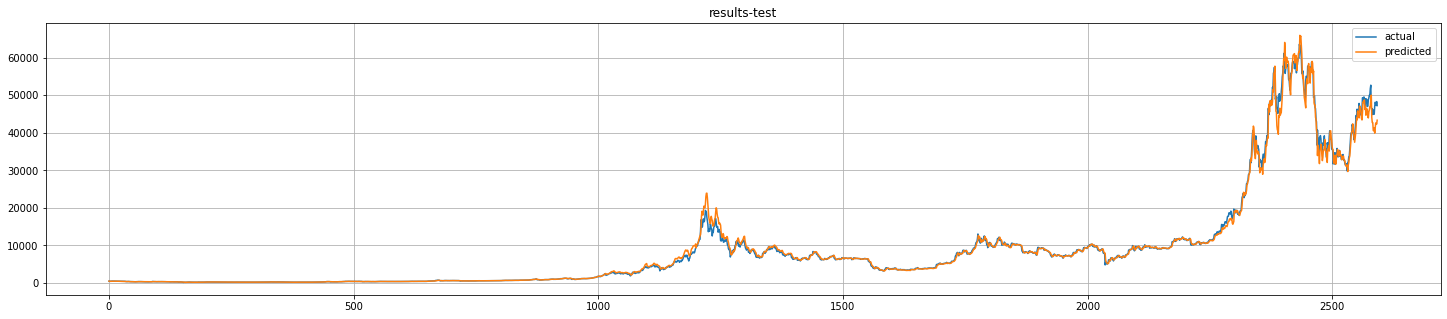

In [25]:
plot_results(bilstm_y_test_array,bilstm_y_test_pred_array,'results-test')

In [21]:
bilstm_result_metrics_df

,batch_id,mae_train,rmse_train,mae_test,rmse_test
0,0,32.512530,60.065944,13.417285,18.699777
1,1,26.627674,53.232408,10.402822,15.378059
2,2,26.973383,52.698435,5.371602,7.551339
3,3,16.209469,34.892814,5.245755,7.280210
4,4,9.169385,14.061930,10.044954,15.815563
5,5,8.634465,13.266607,8.886854,12.900390
6,6,8.007358,12.047154,20.495990,29.682812
7,7,8.042609,14.481144,8.514441,14.429232
8,8,8.349526,15.353379,19.106527,33.741566
9,9,10.914391,21.223066,29.784031,44.053560


In [22]:
pd.DataFrame(bilstm_result_metrics_df.mean()).drop(['batch_id'])

,0
mae_train,160.530271
rmse_train,279.652888
mae_test,431.951980
rmse_test,588.018518


In [ ]:
bilstm_result_metrics_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/bilstm_result_metrics_20210922.csv')
bilstm_result_test_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/bilstm_result_test_20210922.csv')

In [23]:
from sklearn.metrics import mean_absolute_percentage_error

In [24]:
mean_absolute_percentage_error(ytrain_split,ytrain_pred)

0.03139064143846544